In [1]:
import h5py
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# Temperature for the two consecutive timestamp
temperature_fields = []

# Folder Path
path = "solutions"
  
# Read text File  
def read_text_file(file_path):
    with h5py.File(file_path, 'r') as f:
        temperature_fields.append(f['temperature'][:])
        
        
# Iterate through all file
for file in os.listdir(path):
    file_path = f"{path}/{file}"
  
    # call read text file function
    read_text_file(file_path)
    #print(f"{file_path} is finished reading")

temperature_fields = np.asarray(temperature_fields)
print(temperature_fields.shape)

(100, 100, 201, 401)


In [3]:
#Parameters
batch_size = 1

training_data_path = '2D_LSTM_results/LSTM_trainingData_Gadi.txt'
model_path = '2D_LSTM_results/lstm_best.pth'

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
print("Current device is ",device)

# make results determinstic
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Current device is  cpu


In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential( # 1x201x401 => 6x23x45
            nn.Conv2d(1, 3, stride=(3, 3), kernel_size=(5, 5), padding=2),
            nn.Tanh(),
            nn.Conv2d(3, 6, stride=(3, 3), kernel_size=(5, 5), padding=2),
            nn.Tanh(),
        )
        
    def forward(self, x):
        out=self.encoder(x)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential( # 6x23x45 => 201x401
            nn.ConvTranspose2d(6, 3, stride=(3, 3), kernel_size=(5, 5), padding=(2,2)),
            nn.Tanh(),
            nn.ConvTranspose2d(3, 1, stride=(3, 3), kernel_size=(5, 5), padding=(1,0)),
        )
        

    def forward(self, x):
        out=self.decoder(x)
        return out

In [6]:
encoder_path = "2D_ConvAE_results/Conv2D_encoder_best_Gadi.pth"
decoder_path = "2D_ConvAE_results/Conv2D_decoder_best_Gadi.pth"

encoder = Encoder().to(device)
decoder = Decoder().to(device)
encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(decoder_path, map_location=torch.device('cpu')))

print("Encoder and Decoder loaded!")

Encoder and Decoder loaded!


In [7]:
# Customised Dataset class
class KMNIST(Dataset):
    
    def __init__(self, dataset):
        self.input = dataset[:,:50,:,:]
        self.output = dataset[:,50:,:,:]
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        input_item = self.input[index]
        output_item = self.output[index]
        
        return input_item, output_item

In [8]:
temperature_dataset = KMNIST(
    temperature_fields
)


testingAndValidation_split = 0.2
validation_split = 0.1

# Creating data indices for training, testing and validation splits
# Reference: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
temperature_dataset_size = len(temperature_dataset)
temperature_indices = list(range(temperature_dataset_size))

temperature_training_testing_split = int(np.floor(testingAndValidation_split * temperature_dataset_size))
temperature_testing_validation_split = int(np.floor(validation_split * temperature_dataset_size))

np.random.shuffle(temperature_indices)
temperature_train_indices, temperature_val_indices ,temperature_test_indices = temperature_indices[temperature_training_testing_split:], temperature_indices[:temperature_testing_validation_split], temperature_indices[temperature_testing_validation_split:temperature_training_testing_split] 

# Creating data samplers
temperature_train_sampler = SubsetRandomSampler(temperature_train_indices)
temperature_test_sampler = SubsetRandomSampler(temperature_test_indices)
temperature_valid_sampler = SubsetRandomSampler(temperature_val_indices)

train_loader = DataLoader(
    dataset=temperature_dataset,
    batch_size = batch_size,
    sampler=temperature_train_sampler,
)

test_loader = DataLoader(
    dataset=temperature_dataset,
    batch_size = batch_size,
    sampler=temperature_test_sampler,
)

validation_loader = DataLoader(
    dataset=temperature_dataset,
    batch_size = batch_size,
    sampler=temperature_valid_sampler,
)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()    
        self.lstm1 = nn.LSTM(input_size=6210, hidden_size=3105, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=3105, hidden_size=6210, num_layers=1, batch_first=True)
        
    
    def forward(self, x):
        sequence_length = 50
        
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        
        out = out.view(sequence_length,6,23,45)
        
        return out

In [10]:
def test(model, encoder, decoder, test_loader, device):

    # Load the model from the input model_path  
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    criterion = nn.MSELoss()
    total_loss = 0.0
    
    best_worst_error_list = [1000000, 0]
    best_worst_output_list = [0, 0]
    best_worst_predicted_list = [0, 0]
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            encoded_inputs = encoder(inputs.view(inputs.shape[1], 1, 201, 401)).reshape(batch_size, 50, -1)
            encoded_labels = encoder(labels.view(labels.shape[1], 1, 201, 401))

            # Get output features, calculate loss and optimize
            outputs = model(encoded_inputs)
            loss = criterion(outputs.float(), encoded_labels.float())

            for j in range(len(encoded_labels)):
                single_loss = criterion(outputs[j], encoded_labels[j])
                # Record worst error
                if single_loss.item() > best_worst_error_list[1]:
                    best_worst_error_list[1] = single_loss.item()
                    best_worst_output_list[1] = labels[0][j]
                    best_worst_predicted_list[1] = outputs[j]
                    
                # Record best error
                if single_loss.item() < best_worst_error_list[0]:
                    best_worst_error_list[0] = single_loss.item()
                    best_worst_output_list[0] = labels[0][j]
                    best_worst_predicted_list[0] = outputs[j]
                    

            # Add to the validation loss
            total_loss += loss.item()

    # Calculate the overall accuracy and return the accuracy and test loss
    print("Total loss for the model is",total_loss)
    print()
    
    # Draw some plots for the best and the worst error
    print("Best model has a error of ", best_worst_error_list[0])
    
    plt.figure(figsize=(18, 9))
    
    plt.subplot(2,2,1)
    plt.title("Best case output")
    plt.imshow(best_worst_output_list[0].detach().numpy(),
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
    original_size_predicted = decoder(encoder(best_worst_output_list[0].view(1, 1, 201, 401)).view(1, 6, 23, 45))
    
    plt.subplot(2,2,2)
    plt.title("Best case AE output")
    plt.imshow(original_size_predicted.detach().numpy()[0][0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
    
    latent_space_predicted = best_worst_predicted_list[0].view(1, 6, 23, 45)
    original_size_predicted = decoder(latent_space_predicted)
    
    plt.subplot(2,2,3)
    plt.title("Best case predicted output")
    plt.imshow(original_size_predicted.detach().numpy()[0][0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    plt.show()
    
    
    print("Worst model has a error of ", best_worst_error_list[1])
    
    
    plt.figure(figsize=(18, 9))
    
    plt.subplot(2,2,1)
    plt.title("Worst case output")
    plt.imshow(best_worst_output_list[1].detach().numpy(),
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
    original_size_predicted = decoder(encoder(best_worst_output_list[1].view(1, 1, 201, 401)).view(1, 6, 23, 45))
    
    plt.subplot(2,2,2)
    plt.title("Worst case AE output")
    plt.imshow(original_size_predicted.detach().numpy()[0][0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
    
    latent_space_predicted = best_worst_predicted_list[1].view(1, 6, 23, 45)
    original_size_predicted = decoder(latent_space_predicted)
    
    plt.subplot(2,2,3)
    plt.title("Worst case predicted output")
    plt.imshow(original_size_predicted.detach().numpy()[0][0],
              cmap=cm.get_cmap('jet', 10),
              extent=(0, 2, 0, 1))
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    plt.show()
    
    #return 100*correct//total, total_loss

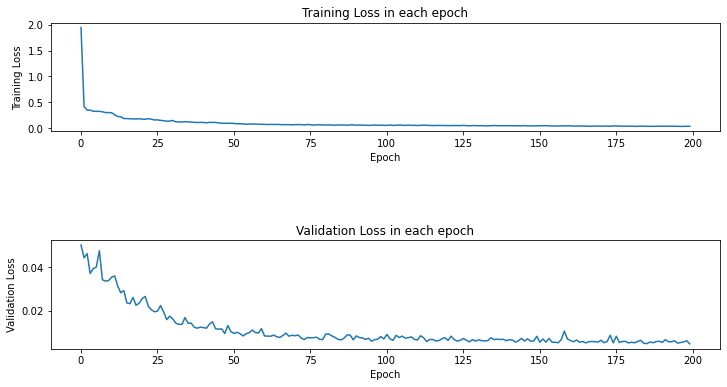

In [11]:
file1 = open(training_data_path, 'r')
Lines = file1.readlines()

training_data_list = []
for line in Lines:
    training_data_list.append([float(x) for x in line.strip().split('/')])
    
# Plot the Training loss and validation loss during training
plt.figure(figsize=(12, 6))
    
plt.subplot(2, 1, 1)
plt.plot(training_data_list[0])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss in each epoch')

plt.subplot(2, 1, 2)
plt.plot(training_data_list[1])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss in each epoch')
    
plt.subplots_adjust(hspace=1)
    
plt.show()

Total loss for the model is 0.003697341730003245

Best model has a error of  9.682823292678222e-05


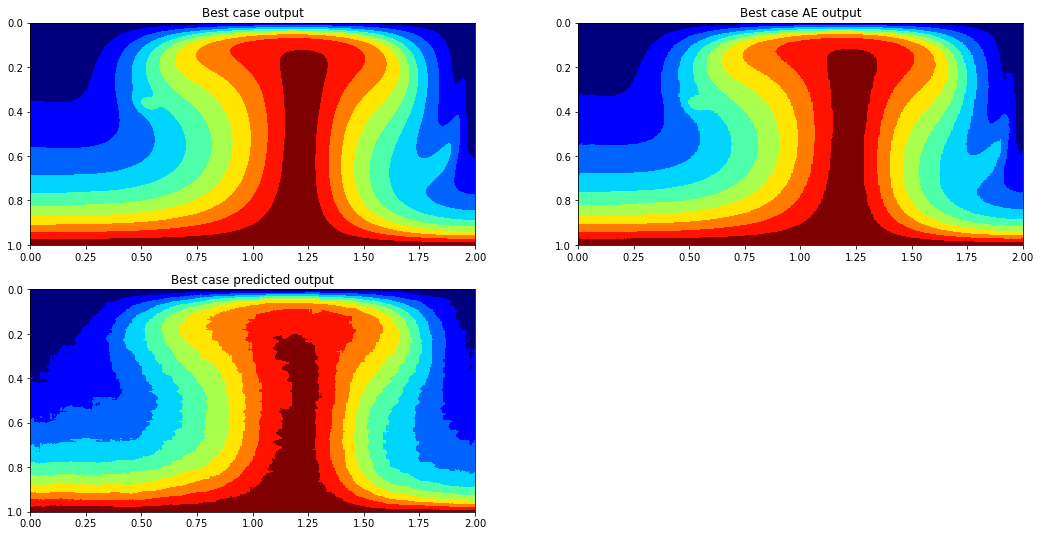

Worst model has a error of  0.007273165509104729


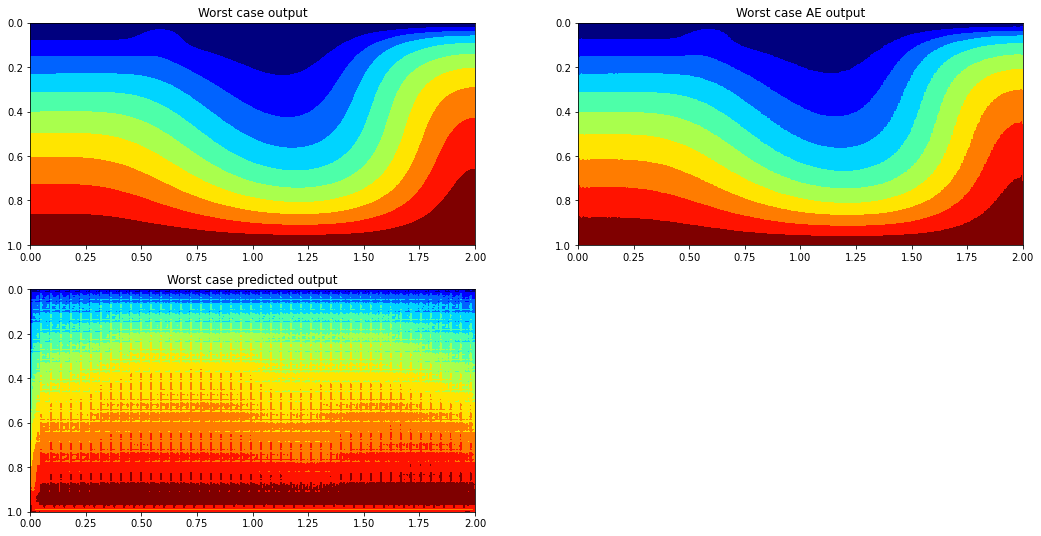

In [13]:
model = Net().to(device)
test(model, encoder, decoder, test_loader, device)

In [17]:
best_evolution = [0,0,0]
worst_evolution = [0,0,0]
best_loss = 1e10
worst_loss = -1

# Test for a complete cycle of timestamps
for testing_file_index in range(100):

    # Read the testing file
    testing_temperature_fields = []
    testing_file_path = path + "/solution_" + str(testing_file_index) +".h5"
    with h5py.File(testing_file_path, 'r') as f:
        testing_temperature_fields = f['temperature'][:]
        
    testing_temperature_fields = np.asarray(testing_temperature_fields)

    # Calculate predicted temperature fields and compressed-decompressed field
    temperature_fields_inputs = testing_temperature_fields[:50,:,:]
    temperature_fields_outputs = testing_temperature_fields[50:,:,:]
    
    encoded_inputs = encoder(torch.from_numpy(temperature_fields_inputs).view(50, 1, 201, 401)).reshape(1, 50, -1)
    predicted_outputs = model(encoded_inputs)
    
    decoded_predicted = decoder(predicted_outputs.view(50, 6, 23, 45)).detach().numpy().reshape(50,201,401)
    decoded_original = decoder(encoded_inputs.view(50, 6, 23, 45)).detach().numpy().reshape(50,201,401)
    
    original_predicted_distance = np.abs(temperature_fields_outputs - decoded_predicted).flatten().sum()
    
    
    print("Loss value for {} is {}".format(testing_file_path, original_predicted_distance))
    if original_predicted_distance < best_loss:
        best_loss = original_predicted_distance
        best_evolution[0] = temperature_fields_outputs
        best_evolution[1] = decoded_predicted
        best_evolution[2] = decoded_original
        print("Best evolution update to ", best_loss)
    
    if original_predicted_distance > worst_loss:
        worst_loss = original_predicted_distance
        worst_evolution[0] = temperature_fields_outputs
        worst_evolution[1] = decoded_predicted
        worst_evolution[2] = decoded_original
        print("Worst evolution update to ", worst_loss)
    print()
    
print("Best evolution has a loss value of ", best_loss)
print("Worst evolution has a loss value of ", worst_loss)

Loss value for solutions/solution_0.h5 is 182142.40625
Best evolution update to  182142.4
Worst evolution update to  182142.4

Loss value for solutions/solution_1.h5 is 165782.296875
Best evolution update to  165782.3

Loss value for solutions/solution_2.h5 is 183604.46875
Worst evolution update to  183604.47

Loss value for solutions/solution_3.h5 is 120911.078125
Best evolution update to  120911.08

Loss value for solutions/solution_4.h5 is 145518.46875

Loss value for solutions/solution_5.h5 is 146170.71875

Loss value for solutions/solution_6.h5 is 196211.4375
Worst evolution update to  196211.44

Loss value for solutions/solution_7.h5 is 169932.640625

Loss value for solutions/solution_8.h5 is 141642.5625

Loss value for solutions/solution_9.h5 is 173631.515625

Loss value for solutions/solution_10.h5 is 118300.28125
Best evolution update to  118300.28

Loss value for solutions/solution_11.h5 is 142920.1875

Loss value for solutions/solution_12.h5 is 202800.390625
Worst evolution 

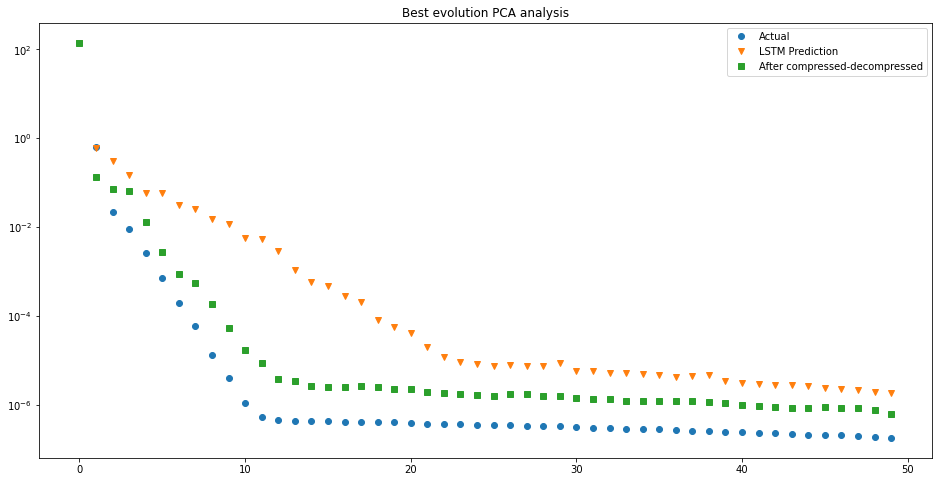

In [20]:
def SVD(X):
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) 
    return U, Sigma, VT

_, S_original_best, _ = SVD(np.transpose(np.asarray(best_evolution[0]),(1,2,0)))
_, S_predicted_best, _ = SVD(np.transpose(np.asarray(best_evolution[1]),(1,2,0)))
_, S_ConvAE_best, _ = SVD(np.transpose(np.asarray(best_evolution[2]),(1,2,0)))

plt.figure(figsize=(16,8))
plt.title("Best evolution PCA analysis")
plt.plot(S_original_best.diagonal(),'o',label="Actual")
plt.plot(S_predicted_best.diagonal(),'v',label="LSTM Prediction")
plt.plot(S_ConvAE_best.diagonal(),'s',label="After compressed-decompressed")
plt.legend()
plt.yscale("log")
plt.show()

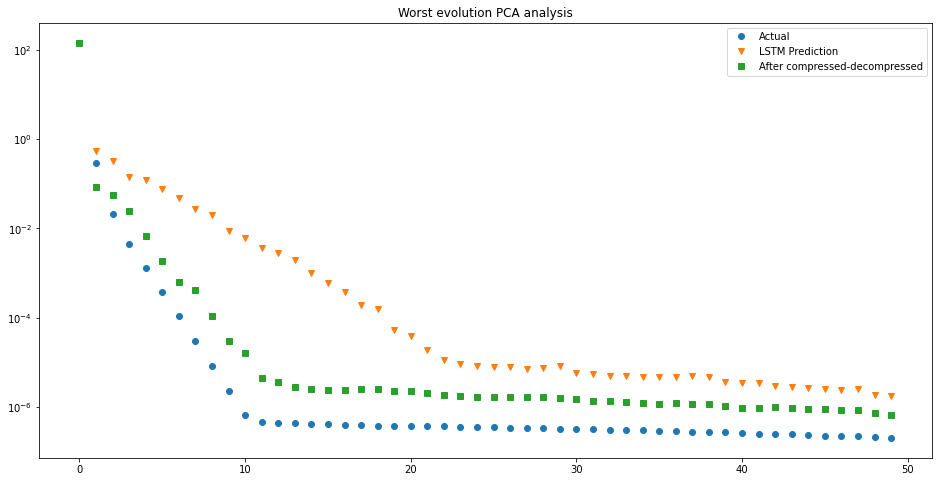

In [21]:
_, S_original_worst, _ = SVD(np.transpose(np.asarray(worst_evolution[0]),(1,2,0)))
_, S_predicted_worst, _ = SVD(np.transpose(np.asarray(worst_evolution[1]),(1,2,0)))
_, S_ConvAE_worst, _ = SVD(np.transpose(np.asarray(worst_evolution[2]),(1,2,0)))

plt.figure(figsize=(16,8))
plt.title("Worst evolution PCA analysis")
plt.plot(S_original_worst.diagonal(),'o',label="Actual")
plt.plot(S_predicted_worst.diagonal(),'v',label="LSTM Prediction")
plt.plot(S_ConvAE_worst.diagonal(),'s',label="After compressed-decompressed")
plt.legend()
plt.yscale("log")
plt.show()

In [22]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# Display animations for temperature fields in different timestamps
fig = plt.figure(figsize=(12, 12))

plt.subplot(2,1,1)
plt.title("Best Actual Temperature fields animation")
plot1= plt.imshow(best_evolution[0][0],
                 cmap=cm.get_cmap('jet', 10),
                 extent=(0, 2, 0, 1))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])


plt.subplot(2,1,2)
plt.title("Best Predicted Temperature fields animation")
plot2= plt.imshow(best_evolution[1][0],
                 cmap=cm.get_cmap('jet', 10),
                 extent=(0, 2, 0, 1))

ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

    
def animate(i):
    plot1.set_data(best_evolution[0][i])
    plot2.set_data(best_evolution[1][i])
    return [plot1,plot2]

anim = FuncAnimation(fig, animate, frames=50, interval=100, blit=True)
anim.save('actual_and_Predictions_Best_LSTM.gif')
plt.close()
HTML(anim.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.


In [23]:
# Display animations for temperature fields in different timestamps
fig = plt.figure(figsize=(12, 12))

plt.subplot(2,1,1)
plt.title("Worst Actual Temperature fields animation")
plot1= plt.imshow(worst_evolution[0][0],
                 cmap=cm.get_cmap('jet', 10),
                 extent=(0, 2, 0, 1))
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])


plt.subplot(2,1,2)
plt.title("Worst Predicted Temperature fields animation")
plot2= plt.imshow(worst_evolution[1][0],
                 cmap=cm.get_cmap('jet', 10),
                 extent=(0, 2, 0, 1))

ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

    
def animate(i):
    plot1.set_data(worst_evolution[0][i])
    plot2.set_data(worst_evolution[1][i])
    return [plot1,plot2]

anim = FuncAnimation(fig, animate, frames=50, interval=100, blit=True)
anim.save('actual_and_Predictions_Worst_LSTM.gif')
plt.close()
HTML(anim.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.
